In [1]:
import itertools
import random
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import KFold

jnp.set_printoptions(precision=2)

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
import data.hyperparam_and_bootstrapping as hb
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow, train_copula_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))


jax.config.update("jax_enable_x64", True)

sweep_configuration = {
    "name": "disc-synth-random",
    "method": "random",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "learning_rate": {"min": 1e-5, "max": 1e-2},
        "RQS_knots": {"min": 1, "max": 10},
        "flow_layers": {"min": 1, "max": 20},
        "nn_width": {"min": 20, "max": 50},
        "nn_depth": {"min": 1, "max": 10},
        # "max_patience": {"min": 1, "max": 20},
        # "max_epochs": {"min": 1, "max": 20},
        "seed": {"min": 0, "max": 100},
    },
}
sweep_id = wandb.sweep(sweep=sweep_configuration, project="frugal-flows")

Create sweep with ID: sbl8uvfn
Sweep URL: https://wandb.ai/dmman180/frugal-flows/sweeps/sbl8uvfn


In [2]:
def generate_discrete_samples(N, causal_params, seed=0):
    disc_rscript = f"""
    library(causl)
    pars <- list(Zc1 = list(beta = c(1), phi=1),
                 Zc2 = list(beta = c(1), phi=2),
                 Zd3 = list(beta = c(0)),
                 Zd4 = list(beta = c(0)),
                 X = list(beta = c(-4,1,1,1,1)),
                 Y = list(beta = c({causal_params[0]}, {causal_params[1]}), phi=1),
                 cop = list(
                   Y=list(
                     Zc1=list(beta=1), Zc2=list(beta=2), Zd3=list(beta=4), Zd4=list(beta=4))
                 )
    )
    forms <- list(list(Zc1~1, Zc2~1, Zd3~1, Zd4~1), X~Zc1+Zc2+Zd3+Zd4, Y~X, ~1)
    
    set.seed({seed})  # for consistency
    fams <- list(c(3,3,5,5),5,1,4)
    data_samples <- rfrugalParam({N}, formulas=forms, family=fams, pars=pars)
    data_samples <- data_samples[!is.infinite(data_samples$Y),]
    """
    data = causl_py.generate_data_samples(disc_rscript)
    return data

N_MAX = 40000
CAUSAL_PARAMS = [0,2]
Z_disc_full, Z_cont_full, X_full, Y_full = generate_discrete_samples(N_MAX, CAUSAL_PARAMS, 2).values()

R[write to console]: Inversion method selected: using pair-copula parameterization



In [ ]:
NUM_SAMPLES = 10000
def run_cmd():
    run = wandb.init()
    hyperparams_dict = {
        "learning_rate": wandb.config.learning_rate,
        "RQS_knots": wandb.config.RQS_knots,
        "flow_layers": wandb.config.flow_layers,
        "nn_width": wandb.config.nn_width,
        "nn_depth": wandb.config.nn_depth,
        "max_patience": 100,#wandb.config.max_patience,
        "max_epochs": 20000#.config.max_epochs
    }

    np.random.seed(wandb.config.seed)
    idx = random.sample(range(N_MAX), NUM_SAMPLES)
    X_samp = X_full[idx,:]
    Y_samp = X_full[idx,:]
    Z_cont_samp = Z_cont_full[idx,:]
    Z_disc_samp = Z_disc_full[idx,:]    
    uz_samples = causl_py.generate_uz_samples(Z_disc=Z_disc_samp, Z_cont=Z_cont_samp, use_marginal_flow=False, seed=wandb.config.seed, frugal_flow_hyperparams=hyperparams_dict)
    # uz_samples = causl_py.generate_uz_samples(Z_disc=None, Z_cont=Z_cont, use_marginal_flow=False, seed=i, frugal_flow_hyperparams=hyperparams_dict)
    frugal_flow, losses = train_frugal_flow(
        key=jr.PRNGKey(wandb.config.seed*1000),
        y=Y_samp,
        u_z=uz_samples['uz_samples'],
        condition=X_samp,
        **hyperparams_dict,
        # causal_model='location_translation',
        # causal_model_args={'ate': 0., **hyperparams_dict}
        causal_model='gaussian',
        causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
    )    
    min_val_loss = min(np.array(losses['val']))
    causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]
    # causal_margin = frugal_flow.bijection.bijections[-1].bijections[0]
    wandb.log(data={'val_loss': min_val_loss, 'ate': causal_margin.ate, 'const': causal_margin.const, 'scale': causal_margin.scale})
    
    
    # causl_py.frugal_fitting(X, Y, Z_disc=Z_disc, seed=wandb.config.seed, frugal_flow_hyperparams=hyperparams_dict)

# Start sweep job.
wandb.agent(sweep_id, function=run_cmd, count=300)
    

# hyperparams_dict = {
#     'learning_rate': 1e-3,
#     'RQS_knots': 8,
#     'flow_layers': 10,
#     'nn_width': 50,
#     'nn_depth': 10,    
#     'max_patience': 100,
#     'max_epochs': 20000
# }

wandb: Agent Starting Run: rfyibzyk with config:
wandb: 	RQS_knots: 6
wandb: 	flow_layers: 3
wandb: 	learning_rate: 0.007170885209044532
wandb: 	nn_depth: 8
wandb: 	nn_width: 25
wandb: 	seed: 91
wandb: Currently logged in as: man180 (dmman180). Use `wandb login --relogin` to force relogin


  2%|█▌                                                                                               | 315/20000 [03:42<3:52:06,  1.41it/s, train=-3.9597336372489824, val=-4.178393593618069 (Max patience reached)]


ate,▁
val_loss,▁
ate,0.99999
val_loss,-5.75394


wandb: Agent Starting Run: 3vyb4mb7 with config:
wandb: 	RQS_knots: 2
wandb: 	flow_layers: 19
wandb: 	learning_rate: 0.0022576659034605003
wandb: 	nn_depth: 8
wandb: 	nn_width: 24
wandb: 	seed: 5


  1%|▋                                                                                                 | 131/20000 [03:28<8:46:36,  1.59s/it, train=-2.699477245640459, val=-2.630207342413408 (Max patience reached)]


ate,▁
val_loss,▁
ate,0.09486
val_loss,-3.69913


wandb: Agent Starting Run: vbab79de with config:
wandb: 	RQS_knots: 8
wandb: 	flow_layers: 4
wandb: 	learning_rate: 0.009711681378849653
wandb: 	nn_depth: 3
wandb: 	nn_width: 46
wandb: 	seed: 48


  1%|▉                                                                                                  | 182/20000 [02:16<4:07:44,  1.33it/s, train=-2.01661482207084, val=-2.820362333324277 (Max patience reached)]


ate,▁
val_loss,▁
ate,0.44145
val_loss,-4.36915


wandb: Agent Starting Run: tygsq81f with config:
wandb: 	RQS_knots: 8
wandb: 	flow_layers: 18
wandb: 	learning_rate: 0.004245620578084446
wandb: 	nn_depth: 2
wandb: 	nn_width: 22
wandb: 	seed: 16


  1%|█▏                                                                                                                     | 193/20000 [04:32<7:15:49,  1.32s/it, train=-1.7727525260606762, val=-2.1519201060883213]wandb: ERROR Error while calling W&B API: could not find agent dp559zgr during agentHeartbeat (<Response [404]>)
Exception in thread Thread-6 (_heartbeat):
Traceback (most recent call last):
  File "/Users/danielmanela/micromamba/envs/deep-frugal/lib/python3.11/site-packages/wandb/sdk/lib/retry.py", line 131, in __call__
    result = self._call_fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/danielmanela/micromamba/envs/deep-frugal/lib/python3.11/site-packages/wandb/sdk/internal/internal_api.py", line 340, in execute
    return self.client.execute(*args, **kwargs)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/danielmanela/micromamba/envs/deep-frugal/lib/python3.11/site-packages/wandb/vendor/gql-0.2.0/wandb_gql/cl

ate,▁
val_loss,▁
ate,0.04268
val_loss,-4.93987


wandb: Sweep Agent: Waiting for job.


In [ ]:
hyperparams_dict = {
    'learning_rate': 0.006335,
    'RQS_knots': 4,
    'flow_layers': 9,
    'nn_depth': 10,    
    'nn_width': 50,
    'max_patience': 200,
    'max_epochs': 20000
}
SEED = 1

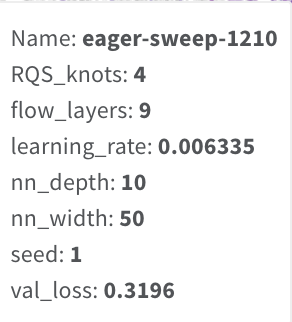

## Load Data

In [ ]:
lalonde = pd.read_csv('../data/filtered_lalonde_dataset.csv')
lalonde.head()

In [ ]:
lalonde = pd.read_csv('../data/filtered_lalonde_dataset.csv')

outcome_col = 're78'
treatment_col = 'treatment'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = lalonde.loc[lalonde[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()
lalonde[standardised_outcome_col] = (lalonde[outcome_col] - Y_control_mean) / Y_control_std
plt.hist(lalonde.loc[lalonde[treatment_col]==0, outcome_col], label='Control', bins=30, alpha=0.3);
plt.hist(lalonde.loc[lalonde[treatment_col]==1, outcome_col], label='Treatment', bins=30, alpha=0.3);

X = jnp.array(lalonde[treatment_col].values)[:, None]
Y = jnp.array(lalonde[standardised_outcome_col].values)[:, None]

Z_disc = jnp.array(lalonde[[
    col for col in lalonde.columns if col not in [outcome_col,standardised_outcome_col, treatment_col]
]].values)

In [ ]:
wandb.init()
flow_object, min_val_loss = causl_py.frugal_fitting(X, Y, Z_disc=Z_disc, seed=SEED+1, frugal_flow_hyperparams=hyperparams_dict)

In [ ]:
min_val_loss

In [ ]:
training_losses = np.array(flow_object['losses']['train'])
val_losses = np.array(flow_object['losses']['val'])
it = list(range(len(flow_object['losses']['train'])))
plt.plot(training_losses, label='Training')
plt.plot(val_losses, label='Test')
plt.legend()

In [ ]:
lalonde = pd.read_csv('../data/filtered_lalonde_dataset.csv')

outcome_col = 're78'
treatment_col = 'treatment'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = lalonde.loc[lalonde[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()
lalonde[standardised_outcome_col] = (lalonde[outcome_col] - Y_control_mean) / Y_control_std
lalonde = lalonde.loc[lalonde[treatment_col]==0]
lalonde = lalonde.loc[lalonde[outcome_col]>0]
# plt.hist(lalonde.loc[lalonde[treatment_col]==0, standardised_outcome_col], label='Control', bins=30, alpha=0.3);
# plt.hist(lalonde.loc[lalonde[treatment_col]==1, standardised_outcome_col], label='Treatment', bins=30, alpha=0.3);

X = jnp.array(lalonde[treatment_col].values)[:, None]
Y = jnp.array(lalonde[standardised_outcome_col].values)[:, None]

Z_disc = jnp.array(lalonde[[
    col for col in lalonde.columns if col not in [outcome_col,standardised_outcome_col, treatment_col]
]].values)

uz_samples = causl_py.generate_uz_samples(seed=0, Z_disc=Z_disc, Z_cont=jnp.array(Y))

In [ ]:
jnp.hstack([uz_samples['uz_cont'], uz_samples['uz_disc']]).shape

In [ ]:
sns.pairplot(
    pd.DataFrame(np.array(jnp.hstack([uz_samples['uz_cont'], uz_samples['uz_disc']]))), 
    diag_kind='kde', plot_kws={'alpha':0.2}, height=1
)

In [ ]:
flow_samples = flow_object['frugal_flow'].sample(
    key=jr.PRNGKey(0), 
    sample_shape=(300,), 
    condition=jnp.zeros(shape=(1))
)
flow_samples = flow_samples.at[:, 0].set(jax.scipy.special.ndtr(flow_samples[:, 0]))
sns.pairplot(pd.DataFrame(np.array(flow_samples[:, ])), diag_kind='kde', plot_kws={'alpha':0.2}, height=1)

In [ ]:
training_losses = np.array(fitted_flow['losses']['train'])
val_losses = np.array(fitted_flow['losses']['val'])
it = list(range(len(fitted_flow['losses']['train'])))
plt.plot(training_losses, label='Training')
plt.plot(val_losses, label='Test')
plt.legend()

In [ ]:
fitted_flow['causal_margin'].ate

In [ ]:
fitted_flow['causal_margin'].const

In [ ]:
fitted_flow['causal_margin'].scale

In [ ]:
flow_samples = fitted_flow['frugal_flow'].sample(
    key=jr.PRNGKey(0), 
    sample_shape=(1000,), 
    condition=jnp.zeros(shape=(1))
)
sns.pairplot(pd.DataFrame(np.array(flow_samples[:, 1:])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
hyperparams_dict_v2 = {
    'learning_rate': 1e-3,
    'RQS_knots': 8,
    'flow_layers': 4,
    'nn_width': 50,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 20000
}

fitted_flow_v2 = causl_py.frugal_fitting(
    X=None, 
    Y=jr.normal(key=jr.PRNGKey(98), shape=(Y.shape[0], 1)), 
    Z_disc=Z_disc, 
    seed=0, 
    frugal_flow_hyperparams=hyperparams_dict_v2
)
flow_v2 = fitted_flow_v2['frugal_flow']

In [ ]:
flow_samples = flow_v2.sample(key=jr.PRNGKey(0), sample_shape=(1000,))#, condition=jnp.zeros(shape=(1,)))

In [ ]:
jnp.corrcoef(jax.scipy.special.ndtri(res['u_z_discr']).T)

In [ ]:
jnp.corrcoef(jax.scipy.special.ndtri(flow_samples[:, 1:]).T)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(flow_samples[:, 1:])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(res['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(res['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
lalonde.value_counts(['black', 'hispanic'])

In [ ]:
sns.pairplot(pd.DataFrame(np.array(Z_disc)), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
sns.pairplot(pd.DataFrame(np.array(res['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6}, height=1)

In [ ]:
def rankdata(z_disc):
    z_disc_ordered = []
    z_rank_mapping = {}
    for d in range(z_disc.shape[1]):
        z_disc_d = z_disc[:, d]
        unique_z_disc_d = jnp.unique(z_disc_d)
        rank_mapping = {k: v for k, v in zip(np.array(unique_z_disc_d), np.arange(len(unique_z_disc_d)))}
        z_disc_new = jnp.array([rank_mapping[i] for i in np.array(z_disc_d)])
        z_disc_ordered.append(z_disc_new)
        z_rank_mapping[d] = rank_mapping
    return jnp.vstack(z_disc_ordered), z_rank_mapping

In [ ]:
Z_disc.shape

In [ ]:
rankdata(Z_disc)[0].shape

In [ ]:
pmf_vals

In [ ]:
pmf_keys

In [ ]:
z_discr_empirical_pmf.cumsum()

In [ ]:
z_discr_empirical_pmf

In [ ]:
def uniform_shift(standard_uniform, upper_index):
    # Function to handle the case where upper_index != 0
    def not_zero():
        lower = z_discr_empirical_cdf_long[upper_index - 1]
        upper = z_discr_empirical_cdf_long[upper_index]
        return standard_uniform * (upper - lower) + lower

    # Function to handle the case where upper_index == 0
    def zero():
        upper = z_discr_empirical_cdf_long[upper_index]
        return standard_uniform * upper

In [ ]:
uniform_shift(0.5, 3)

In [ ]:
plt.hist(Z_disc[:,0])

In [ ]:
plt.hist(causl_py.calculate_ecdf(Z_disc[:,0][:, None]).T)

In [ ]:
temp = Z_disc[:,

In [ ]:
z_disc_new

In [ ]:
sns.pairplot(pd.DataFrame(np.array(Z_disc)), diag_kind='kde', plot_kws={'alpha':0.6})

In [ ]:
quantiles['u_z_discr'][:,0]

In [ ]:
sns.pairplot(pd.DataFrame(np.array(quantiles['u_z_discr'])), diag_kind='kde', plot_kws={'alpha':0.6})

In [ ]:
Z_disc[:,0][:,None]

In [ ]:
actual_quantiles = get_independent_quantiles(
    key=jr.PRNGKey(0), z_cont=Z_disc[:,0][:,None], z_discr=Z_disc[:,1:], **hyperparams_dict
)

In [ ]:
actual_quantiles['u_z_cont']

In [ ]:
sns.pairplot(pd.DataFrame(np.array(actual_quantiles)), diag_kind='kde', plot_kws={'alpha':0.6})

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(pd.DataFrame(np.array(fitted_flow['uz_disc']).T), diag_kind='kde', plot_kws={'alpha':0.6})
plt.show()

In [ ]:
data = causl_py.generate_gaussian_samples(N=1000, causal_params=[1,1], seed=0)
Z_cont = data.get('Z_cont')
X = data.get('X')
Y = data.get('Y')

In [ ]:
# Define the hyperparameter ranges
param_grid = {
    'RQS_knots': [4, 6, 8],
    'flow_layers': [4, 6, 8],
    'nn_width': [20, 40, 60],
    'nn_depth': [4, 6, 8],
    'learning_rate': [3e-3, 5e-3],
    'batch_size': [1000],
    'max_patience': [50],
    'max_epochs': [10000]
}

param_combinations = hb.generate_param_combinations(param_grid)

In [ ]:
hyperparam_fits = hb.gaussian_outcome_hyperparameter_search(
    X, Y, Z_disc=None, Z_cont=Z_cont, param_combinations=param_combinations, seed=0
)

In [ ]:
hyperparam_fits.sort_values('min_loss').head(20)